<a href="https://colab.research.google.com/github/nadira1187/Image-classification-using-deep-learning/blob/main/Fruit_Image_classification_using_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import required libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize


Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATASET_DIR = "/content/drive/MyDrive/Fruits"

TRAIN_DIR = DATASET_DIR + "/train"
TEST_DIR = DATASET_DIR + "/test"
os.listdir('/content/drive/MyDrive/Fruits/train')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Pineapple', 'Apple', 'Grapes', 'Orange', 'Strawberry']

Data Preprocessing & Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)


### Visualize Augmented Training Images (Class Indices)

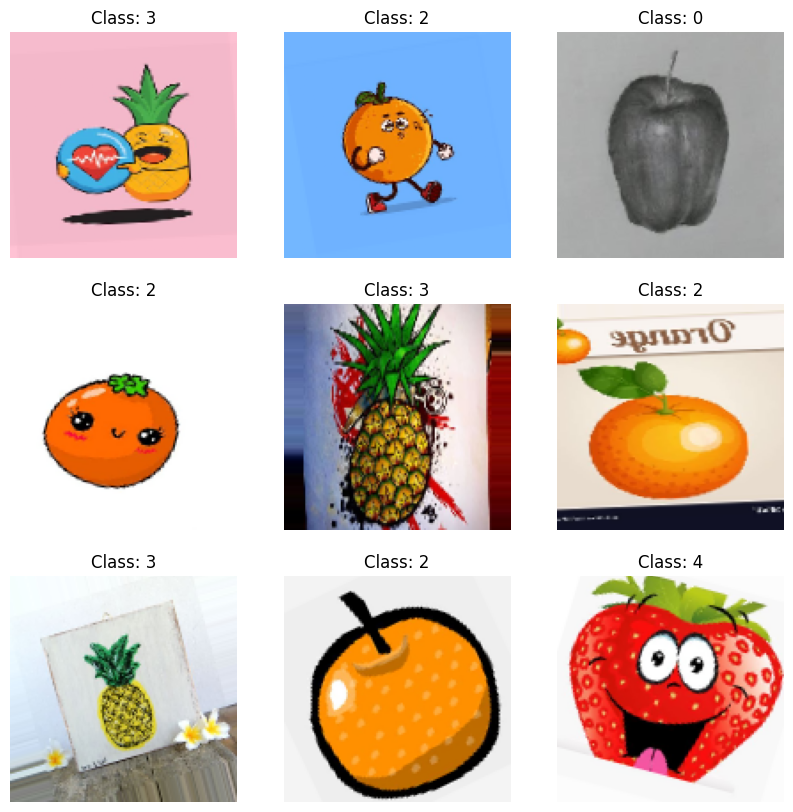

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of training images and labels
images, labels = next(train_generator)

# Display the first few images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[i].argmax()}") # Display the class index
    plt.axis("off")
plt.show()

Here, `labels[i].argmax()` gives the index of the class for each image. To see the actual class names, we can map these indices back to the class names from `train_generator.class_indices`.

### Visualize Augmented Training Images (Class Names)

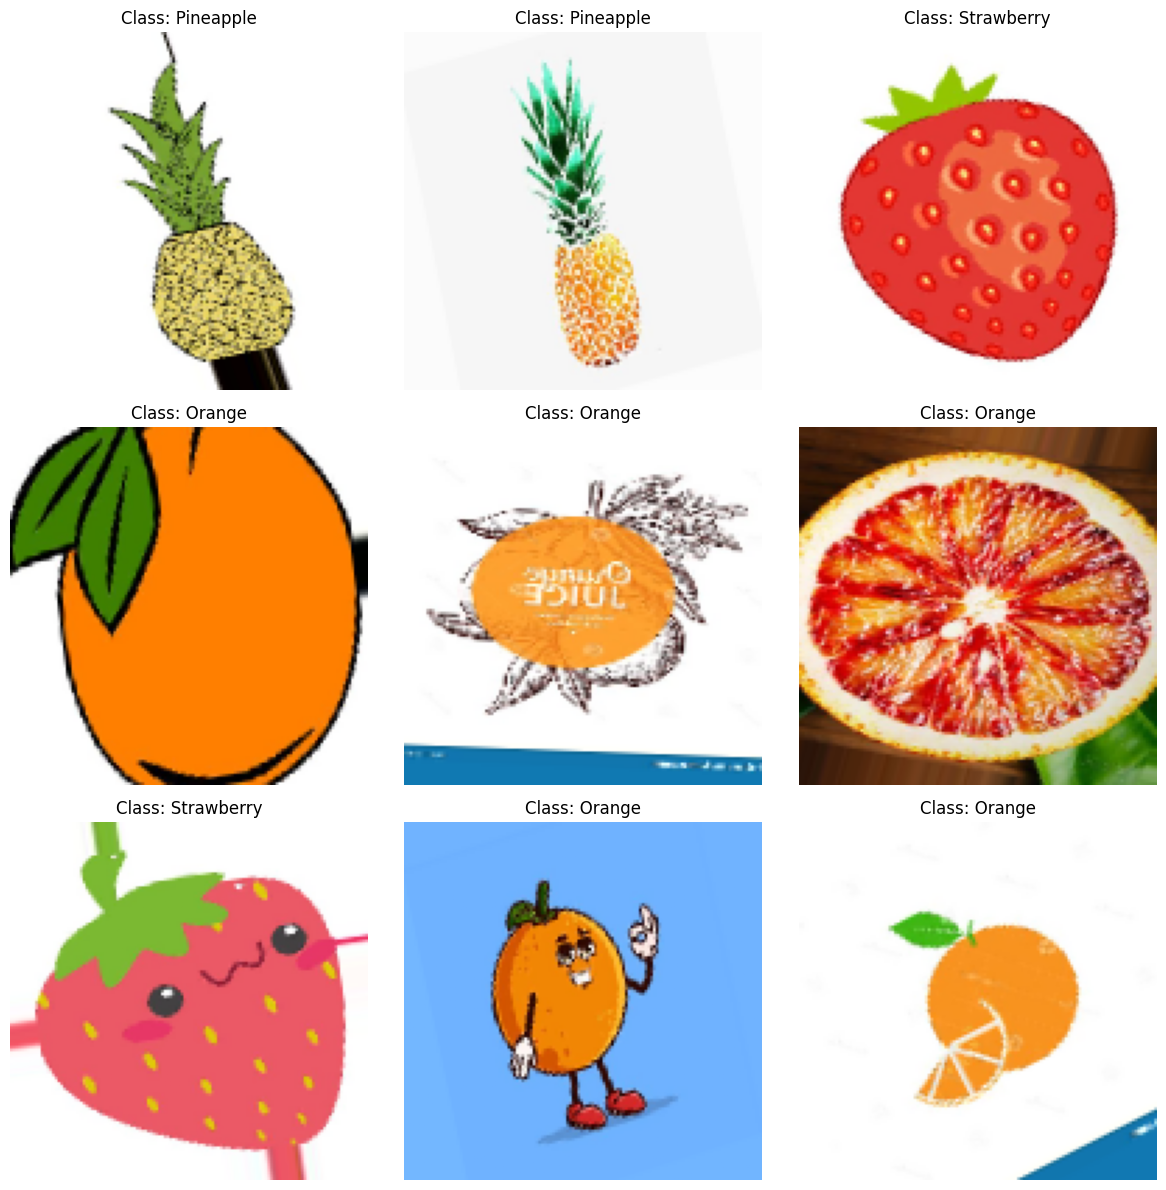

In [ ]:
import matplotlib.pyplot as plt

# Get class names from the generator
class_names = list(train_generator.class_indices.keys())

# Get a batch of training images and labels again (they will be augmented differently each time)
images, labels = next(train_generator)

# Display the first few images with their class names
plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    predicted_class_index = labels[i].argmax()
    plt.title(f"Class: {class_names[predicted_class_index]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

### Define MobileNetV2 Base Model

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(128, 128, 3)
)

base_model.trainable = False


Transfer Learning Model

In [ ]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation="softmax")
])

Found 800 images belonging to 5 classes.


### Compile and Summarize Model

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Define Early Stopping Callback

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)


### Prepare Test Data and Train Model

In [ ]:
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=15,
    callbacks=[early_stop]
)

Found 200 images belonging to 5 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.2056 - loss: 2.1449 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 414s 16s/step - accuracy: 0.2074 - loss: 2.1347 - val_accuracy: 0.5650 - val_loss: 1.1628
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 275ms/step - accuracy: 0.4735 - loss: 1.3766 - val_accuracy: 0.7250 - val_loss: 0.8295
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 321ms/step - accuracy: 0.6306 - loss: 0.9830 - val_accuracy: 0.8050 - val_loss: 0.6548
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 304ms/step - accuracy: 0.7195 - loss: 0.8378 - val_accuracy: 0.8500 - val_loss: 0.5365
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - accuracy: 0.7641 - loss: 0.7001 - val_accuracy: 0.8800 - val_loss: 0.4593
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 329ms/step - accuracy: 0.7832 - loss: 0.6463 - val_accuracy: 0.8900 - val_loss: 0.4023
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.8213 - loss: 0.5453 - val_accuracy: 0.9100 - val_loss: 0.3597
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 318ms/step - accuracy: 0.8632 - loss: 0.4317 - val_accuracy: 0.9200 - val_

### Make Predictions on Test Data

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step


### Predict on a Single Test Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


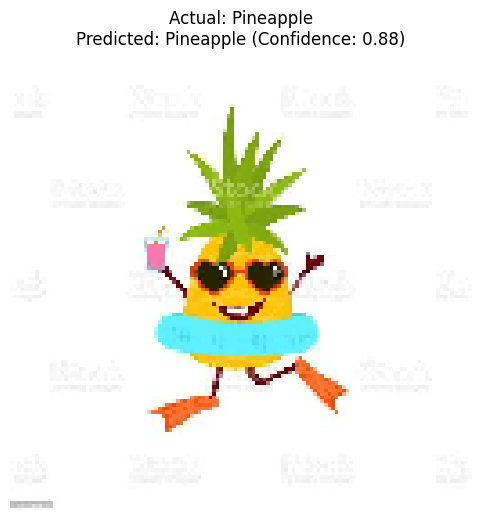

In [ ]:
import random
import os
from tensorflow.keras.preprocessing import image
import numpy as np

# Get a list of all class directories in the test set
test_class_dirs = [d for d in os.listdir(TEST_DIR) if os.path.isdir(os.path.join(TEST_DIR, d))]

# Choose a random class directory
random_class = random.choice(test_class_dirs)
random_class_path = os.path.join(TEST_DIR, random_class)

# Get all image files in that random class directory
image_files = [f for f in os.listdir(random_class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Choose a random image from that class
random_image_file = random.choice(image_files)
image_path = os.path.join(random_class_path, random_image_file)

# Load and preprocess the image
img = image.load_img(image_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Rescale

# Make prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])

# Get class names from train_generator
class_names = list(train_generator.class_indices.keys())
predicted_class_name = class_names[predicted_class_index]
actual_class_name = random_class # The directory name is the actual class

# Display the image and prediction
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"Actual: {actual_class_name}\nPredicted: {predicted_class_name} (Confidence: {predictions[0][predicted_class_index]:.2f})")
plt.axis("off")
plt.show()


### Display Classification Report

In [ ]:
print(classification_report(
    y_true,
    y_pred,
    target_names=train_generator.class_indices.keys()
))

              precision    recall  f1-score   support

       Apple       0.93      0.95      0.94        40
      Grapes       0.97      0.95      0.96        40
      Orange       0.90      0.93      0.91        40
   Pineapple       0.95      0.95      0.95        40
  Strawberry       0.92      0.90      0.91        40

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200



### Visualize Confusion Matrix

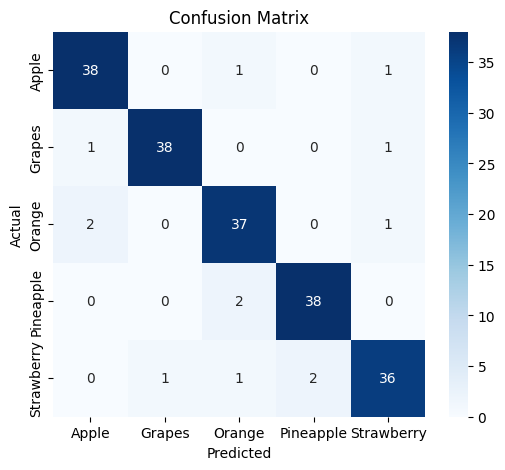

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Calculate and Plot ROC AUC

Macro AUC: 0.99159375


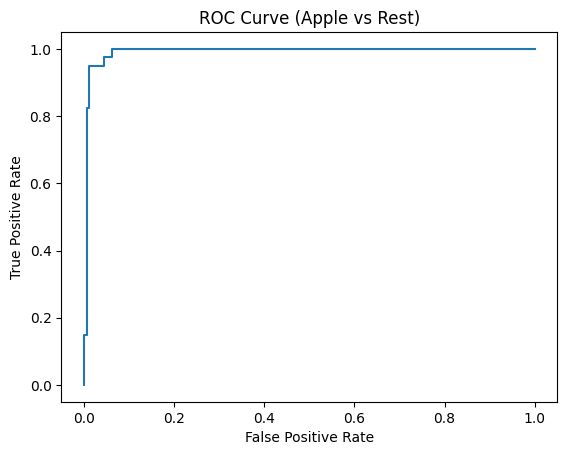

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve

y_true_bin = label_binarize(y_true, classes=range(train_generator.num_classes))
auc = roc_auc_score(y_true_bin, y_prob, average="macro", multi_class="ovo")
print("Macro AUC:", auc)

fpr, tpr, _ = roc_curve(y_true_bin[:,0], y_prob[:,0])
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Apple vs Rest)")
plt.show()

### Save the Trained Model

In [ ]:
model.save("/content/drive/MyDrive/Fruits_fruit_classifier.h5")
